## License Plate Detection Using YoloV8

### For Video Processing

In [19]:
from ultralytics import YOLO
import cv2
import util
from sort.sort import *
from util import get_car, read_license_plate, write_csv

# Set the GPU device
import torch
torch.cuda.set_device(0) # Set to your desired GPU number

results = {}

mot_tracker = Sort()

# Load YOLO models
coco_model = YOLO('yolo_models/yolov8n.pt')
license_plate_detector = YOLO('yolo_models/license_plate_detector.pt')

In [20]:
# load video
cap = cv2.VideoCapture('pexels_videos_2103099 (1080p).mp4')

vehicles = [2, 3, 5, 7]

# read frames
frame_nmr = -1
ret = True
while ret:
    frame_nmr += 1
    ret, frame = cap.read()
    if ret:
        results[frame_nmr] = {}
        # detect vehicles
        detections = coco_model(frame)[0]
        detections_ = []
        for detection in detections.boxes.data.tolist():
            x1, y1, x2, y2, score, class_id = detection
            if int(class_id) in vehicles:
                detections_.append([x1, y1, x2, y2, score])

        # track vehicles
        track_ids = mot_tracker.update(np.asarray(detections_))

        # detect license plates
        license_plates = license_plate_detector(frame)[0]
        for license_plate in license_plates.boxes.data.tolist():
            x1, y1, x2, y2, score, class_id = license_plate

            # assign license plate to car
            xcar1, ycar1, xcar2, ycar2, car_id = get_car(license_plate, track_ids)

            if car_id != -1:
                # crop license plate from the original image
                license_plate_crop_original = frame[int(y1):int(y2), int(x1):int(x2), :]

                # Save the license plate with the same resolution as the original input image
                output_path = f"Datasets/pexels_video/license_plate_{frame_nmr}_{car_id}.jpg"
                cv2.imwrite(output_path, license_plate_crop_original)


0: 384x640 20 cars, 1 bus, 2 trucks, 71.2ms
Speed: 7.2ms preprocess, 71.2ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 license_plates, 61.8ms
Speed: 3.2ms preprocess, 61.8ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 22 cars, 1 bus, 2 trucks, 68.1ms
Speed: 4.1ms preprocess, 68.1ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 license_plates, 60.9ms
Speed: 4.0ms preprocess, 60.9ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 22 cars, 1 bus, 2 trucks, 68.8ms
Speed: 6.4ms preprocess, 68.8ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 license_plates, 60.3ms
Speed: 3.9ms preprocess, 60.3ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 24 cars, 1 bus, 3 trucks, 68.2ms
Speed: 5.0ms preprocess, 68.2ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 license_plates, 

### For Image Processing

In [1]:
from ultralytics import YOLO
import cv2
from sort.sort import *
from util import get_car

# Set the GPU device
# import torch
# torch.cuda.set_device(0) # Set to your desired GPU number

# Load YOLO models
coco_model = YOLO('yolo_models/yolov8n.pt')
license_plate_detector = YOLO('yolo_models/license_plate_detector.pt')

# Initialize SORT tracker
mot_tracker = Sort()

def process_image(image):
    # detect vehicles
    detections = coco_model(image)[0]
    detections_ = []
    for detection in detections.boxes.data.tolist():
        x1, y1, x2, y2, score, class_id = detection
        # Considering only certain classes as vehicles
        vehicles = [2, 3, 5, 7]
        if int(class_id) in vehicles:
            detections_.append([x1, y1, x2, y2, score])

    # track vehicles
    track_ids = mot_tracker.update(np.asarray(detections_))

    # detect license plates
    license_plates = license_plate_detector(image)[0]
    license_plate_results = []
    lp_crop = None
    for license_plate in license_plates.boxes.data.tolist():
        x1, y1, x2, y2, score, class_id = license_plate
        
        # crop license plate from the original image
        license_plate_crop_original = image[int(y1):int(y2), int(x1):int(x2), :]
        lp_crop = license_plate_crop_original
        # assign license plate to car
        xcar1, ycar1, xcar2, ycar2, car_id = get_car(license_plate, track_ids)
        
        if car_id != -1:
            license_plate_results.append((car_id, license_plate_crop_original))
        else:
            continue

    return license_plate_results, lp_crop

In [2]:
# Process the image
img = cv2.imread('images/pakcar2.jpg')
lp_results, lp_img_crop = process_image(img)

2024-02-13 23:58:10.302106: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-13 23:58:10.302658: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-13 23:58:11.945366: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered

0: 352x640 (no detections), 180.2ms
Speed: 20663.4ms preprocess, 180.2ms inference, 161.2ms postprocess per image at shape (1, 3, 640, 640)

0: 352x640 1 license_plate, 82.1ms
Speed: 4.3ms preprocess, 82.1ms inference, 89.0ms postprocess per image at shape (1, 3, 640, 640)


## Character Segmentation

### Finding the License Plate Characters

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import statistics as st
%matplotlib inline

def find_contours(dimensions, img):
    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]

    # Check largest 5 or 15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]

    ii = cv2.imread('contour.jpg')

    x_cntr_list = []
    img_res = []
    widths = []
    heights = []
    contours = []  # Store contour coordinates here

    # Calculate the middle line of the license plate
    middle_line = img.shape[0] // 2

    # Sort contours based on x-coordinate and then on y-coordinate
    sorted_cntrs = sorted(cntrs, key=lambda c: (c[0][0][0], c[0][0][1]))

    # Separate contours above and below the middle line
    above_middle = []
    below_middle = []
    for cntr in sorted_cntrs:
        x, y, w, h = cv2.boundingRect(cntr)

        if y < middle_line:
            above_middle.append((x, y, w, h, cntr))
        else:
            below_middle.append((x, y, w, h, cntr))

    # Sort contours from left to right
    above_middle = sorted(above_middle, key=lambda c: c[0])
    below_middle = sorted(below_middle, key=lambda c: c[0])

    # Process contours above the middle line
    for x, y, w, h, cntr in above_middle:
        if w > lower_width and w < upper_width and h > lower_height and h < upper_height:
            char = img[y:y+h, x:x+w]
            white_pixels = np.sum(char == 255)
            total_pixels = char.size
            white_percentage = (white_pixels / total_pixels) * 100

            if white_percentage >= 25:
                x_cntr_list.append((x, y))  # stores the (x, y) coordinates of the character's contour
                widths.append(w)
                heights.append(h)
                contours.append((x, y, x+w, y+h))  # Append contour coordinates
                
                char_copy = np.zeros((44, 24))
                # Extracting each character using the enclosing rectangle's coordinates.
                char = cv2.resize(char, (20, 40))

                cv2.rectangle(ii, (x, y), (x+w, y+h), (50, 21, 200), 2)
                plt.imshow(ii, cmap='gray')

                # Make result formatted for classification: invert colors
                char = cv2.subtract(255, char)

                # Resize the image to 24x44 with a black border
                char_copy[2:42, 2:22] = char
                char_copy[0:2, :] = 0
                char_copy[:, 0:2] = 0
                char_copy[42:44, :] = 0
                char_copy[:, 22:24] = 0

                img_res.append(char_copy)  # List that stores the character's binary image (unsorted)

    # Process contours below the middle line
    for x, y, w, h, cntr in below_middle:
        if w > lower_width and w < upper_width and h > lower_height and h < upper_height:
            char = img[y:y+h, x:x+w]
            white_pixels = np.sum(char == 255)
            total_pixels = char.size
            white_percentage = (white_pixels / total_pixels) * 100

            if white_percentage >= 25:
                x_cntr_list.append((x, y))  # stores the (x, y) coordinates of the character's contour
                widths.append(w)
                heights.append(h)
                contours.append((x, y, x+w, y+h))  # Append contour coordinates
                
                char_copy = np.zeros((44, 24))
                # Extracting each character using the enclosing rectangle's coordinates.
                char = cv2.resize(char, (20, 40))

                cv2.rectangle(ii, (x, y), (x+w, y+h), (50, 21, 200), 2)
                plt.imshow(ii, cmap='gray')

                # Make result formatted for classification: invert colors
                char = cv2.subtract(255, char)

                # Resize the image to 24x44 with a black border
                char_copy[2:42, 2:22] = char
                char_copy[0:2, :] = 0
                char_copy[:, 0:2] = 0
                char_copy[42:44, :] = 0
                char_copy[:, 22:24] = 0

                img_res.append(char_copy)  # List that stores the character's binary image (unsorted)

    # Calculate median width and height
    median_width = st.median(widths)
    median_height = st.median(heights)
    
    # Filter characters based on width and height deviation from the median
    filtered_img_res = []
    filtered_contours = []
    for char, contour in zip(img_res, contours):
        x1, y1, x2, y2 = contour
        if ((x2 - x1) >= 0.70 * median_width) and ((x2 - x1) <= 1.3 * median_width) and ((y2 - y1) >= 0.70 * median_height) and ((y2 - y1) <= 1.3 * median_height):
            filtered_img_res.append(char)
            filtered_contours.append(contour)

    # Remove contours with a distance of more than 15 pixels between them
    remaining_contours = []
    remaining_filtered_img_res = []
    if len(filtered_contours) > 1:
        center_x = img.shape[1] / 3
        distance = 0
        count = 1
        for i in range(1, len(filtered_contours)):
            if count >= len(filtered_contours):
                break
            x1_prev, _, x2_prev, _ = filtered_contours[count - 1]
            x1_curr, _, x2_curr, _ = filtered_contours[count]
            distance = x1_curr - x2_prev
            print (f"Distance between contours {count} and {count+1}: {distance}")
            if distance <= -175:
                count += 1
                continue
            elif distance <= 15:
                print("if (distance <= 15):")
                remaining_contours.append(filtered_contours[count - 1])
                remaining_filtered_img_res.append(filtered_img_res[count - 1])
                count += 1
            elif x1_curr < center_x:
                print("elif x1_curr < center_x:")
                remaining_contours.append(filtered_contours[count])
                remaining_filtered_img_res.append(filtered_img_res[count])
                count +=2
            elif x1_curr >= (center_x * 2):
                print("elif x1_curr >= center_x:")
                remaining_contours.append(filtered_contours[count - 1])
                remaining_filtered_img_res.append(filtered_img_res[count - 1])
                count +=2
            else:
                print("else:")
                remaining_contours.append(filtered_contours[count - 1])
                remaining_filtered_img_res.append(filtered_img_res[count - 1])
                count += 1

        print("Last contour")
        remaining_contours.append(filtered_contours[-1])
        remaining_filtered_img_res.append(filtered_img_res[-1])

    plt.show()

    return np.array(remaining_filtered_img_res)

### Segmenting the Characters

In [4]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255
    
    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/10,
                  2*LP_WIDTH/2.5,
                  LP_HEIGHT/20,
                  2*LP_HEIGHT/2.5]
    
    plt.show()
    cv2.imwrite('contour.jpg', img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)
    
    return char_list

### Test the function

Distance between contours 1 and 2: 6
if (distance <= 15):
Distance between contours 2 and 3: 7
if (distance <= 15):
Distance between contours 3 and 4: 59
elif x1_curr >= center_x:
Distance between contours 5 and 6: -283
Distance between contours 6 and 7: 6
if (distance <= 15):
Distance between contours 7 and 8: 6
if (distance <= 15):
Distance between contours 8 and 9: 7
if (distance <= 15):
Last contour


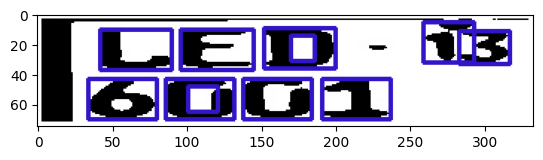

array([[[          0,           0,           0, ...,           0,           0,           0],
        [          0,           0,           0, ...,           0,           0,           0],
        [          0,           0,           0, ...,           0,           0,           0],
        ...,
        [          0,           0,           0, ...,           0,           0,           0],
        [          0,           0,           0, ...,           0,           0,           0],
        [          0,           0,           0, ...,           0,           0,           0]],

       [[          0,           0,           0, ...,           0,           0,           0],
        [          0,           0,           0, ...,           0,           0,           0],
        [          0,           0,           0, ...,           0,           0,           0],
        ...,
        [          0,           0,           0, ...,           0,           0,           0],
        [          0,           0,        

In [5]:
# Reading image from disk
# img = cv2.imread('images/pakcar2.jpg')
# char = segment_characters(img)

# Reading cropped license plate image
char = segment_characters(lp_img_crop)
char

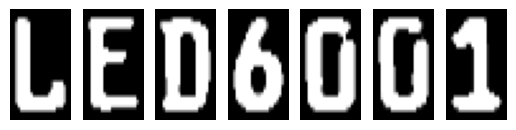

In [6]:
for i in range(len(char)):
    plt.subplot(1, len(char), i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')

## Model for Characters Recognition

In [12]:
# importing required libraries
import json
import tensorflow as tf
from tensorflow.keras.models import save_model, load_model, Sequential
from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
from tensorflow.keras import optimizers

In [9]:
# Loading model architecture
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
# train_generator = train_datagen.flow_from_directory(
#         'CNN_Dataset/data/train',  # this is the target directory
#         target_size=(28,28),  # all images will be resized to 28x28
#         batch_size=1,
#         class_mode='categorical')

# validation_generator = train_datagen.flow_from_directory(
#         'CNN_Dataset/data/val',  # this is the target directory
#         target_size=(28,28),  # all images will be resized to 28x28
#         batch_size=1,
#         class_mode='categorical')

Found 864 images belonging to 36 classes.
Found 216 images belonging to 36 classes.


In [10]:
# Loading model architecture
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
train_generator = train_datagen.flow_from_directory(
        'CNN_Dataset/custom_lp_dataset/train',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
        'CNN_Dataset/custom_lp_dataset/val',  # this is the target directory
        target_size=(28,28),  # all images will be resized to 28x28
        batch_size=1,
        class_mode='categorical')

Found 1903 images belonging to 36 classes.
Found 458 images belonging to 36 classes.


In [10]:
# Defining model
model = Sequential()
model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(4, 4)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(36, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.00001), metrics=['accuracy'])
model.summary()

2024-01-12 10:44:17.877015: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-12 10:44:17.971915: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-12 10:44:17.972122: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-12 10:44:17.977657: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-12 10:44:17.977823: I external/local_xla/xla/stream_executor

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        23248     
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        131104    
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        131136    
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        65600     
                                                                 
 max_pooling2d (MaxPooling2  (None, 7, 7, 64)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 7, 7, 64)          0         
                                                        

In [29]:
# model fitting with early stopping callback to prevent overfitting
class stop_training_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=True):
    # if(logs.get('val_acc') > 0.992):
    val_acc = logs.get('val_acc')
    print(logs)
    if val_acc and val_acc > 0.98:
      self.model.stop_training = True

import datetime
!rm -rf logs
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
batch_size = 1
callbacks = [tensorboard_callback, stop_training_callback()]

history = model.fit(
      train_generator,
      steps_per_epoch = train_generator.samples // batch_size,
      validation_data = validation_generator, 
      validation_steps = validation_generator.samples // batch_size,
      epochs = 80, callbacks=callbacks)

Epoch 1/80
864/864 [==============================] - 26s 30ms/step - loss: 1.2805 - accuracy: 0.6146
Epoch 2/80
864/864 [==============================] - 28s 32ms/step - loss: 1.0808 - accuracy: 0.6887
Epoch 3/80
864/864 [==============================] - 27s 32ms/step - loss: 0.9470 - accuracy: 0.6979
Epoch 4/80
864/864 [==============================] - 33s 38ms/step - loss: 0.8616 - accuracy: 0.7303
Epoch 5/80
864/864 [==============================] - 30s 35ms/step - loss: 0.8163 - accuracy: 0.7350
Epoch 6/80
864/864 [==============================] - 31s 36ms/step - loss: 0.7195 - accuracy: 0.7674
Epoch 7/80
864/864 [==============================] - 34s 39ms/step - loss: 0.6110 - accuracy: 0.8032
Epoch 8/80
864/864 [==============================] - 37s 43ms/step - loss: 0.6306 - accuracy: 0.8067
Epoch 9/80
864/864 [==============================] - 40s 47ms/step - loss: 0.5476 - accuracy: 0.8137
Epoch 10/80
864/864 [==============================] - 47s 54ms/step - loss: 0.502

### Saving and Loading the Model

In [ ]:
# Saving model to disk
save_model(model, "updated_tfkmodel.keras")
model.save('new_model.keras')

# Save History
import numpy as np
model_history = {key: np.array(value).tolist() for key, value in history.history.items()}
import json
with open('history.json', 'w') as f:
    json.dump(model_history, f)

In [13]:
# loading trained model from disk
model = load_model('updated_tfkmodel.keras')
model.summary()

# Loading History
with open('history.json', 'r') as f:
    load_model_history = json.load(f)
loaded_history = {key: np.array(value) for key, value in load_model_history.items()}

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 16)        23248     
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        131104    
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        131136    
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        65600     
                                                                 
 max_pooling2d (MaxPooling2  (None, 7, 7, 64)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 7, 7, 64)          0         
                                                        

### Model Evaluation

In [14]:
# evaluate the model
scores = model.evaluate(validation_generator, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

accuracy: 99.13%


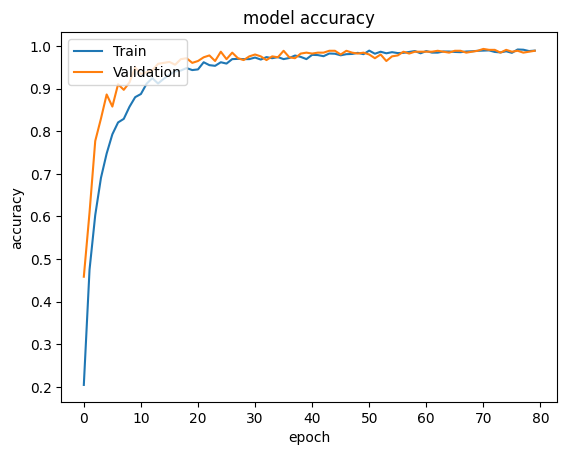

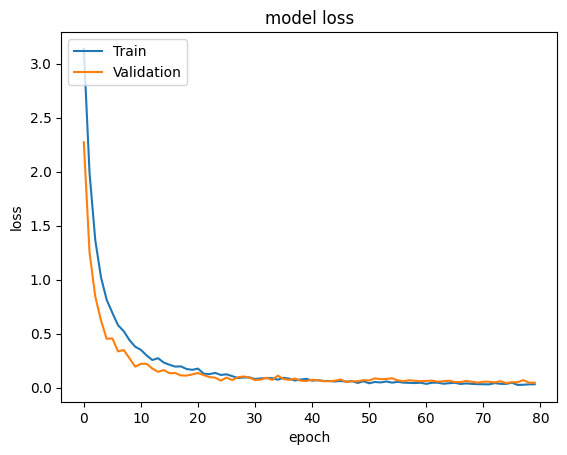

In [15]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(loaded_history['accuracy'])
plt.plot(loaded_history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(loaded_history['loss'])
plt.plot(loaded_history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Infer Characters From The Image

In [16]:
# Preprocess input image for character prediction
def fix_dimension(img): 
  new_img = np.zeros((28,28,3))
  for i in range(3):
    new_img[:,:,i] = img
  return new_img


def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i,c in enumerate(characters):
        dic[i] = c

    output = []
    for i,ch in enumerate(char): # iterating over the characters
        img_ = cv2.resize(ch, (28,28))
        img = fix_dimension(img_)
        img = img.reshape(1,28,28,3) # preparing image for the model
        # y_ = model.predict_classes(img)[0] # predicting the class
        predict_x= model.predict(img)
        classes_x = int(np.argmax(predict_x, axis=1)[0])
        character = dic[classes_x] #
        output.append(character) # storing the result in a list
        
    plate_number = ''.join(output)
    
    return plate_number
lp_number = show_results()
print(lp_number)

1/1 [==============================] - 0s 28ms/step
LED6001


In [17]:
print(f"Recognized license plate characters: {lp_number}") # detected license plate

Recognized license plate characters: LED6001


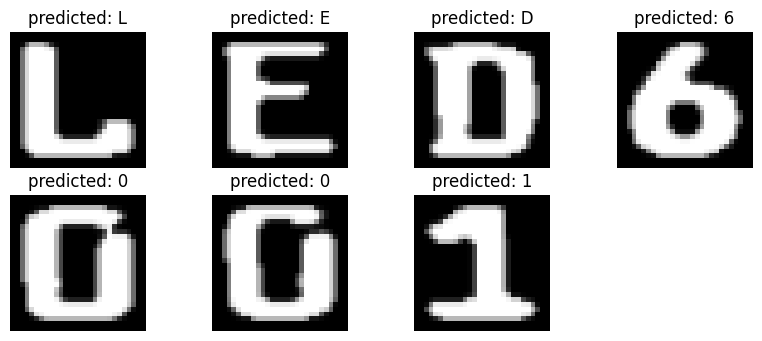

In [18]:
# Displaying segmented and recognized characters along with predicted labels
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28))
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {lp_number[i]}')
    plt.axis('off')
plt.show()